In [1]:
import os

import numpy as np
import pandas as pd

from sklearn import model_selection
from sklearn import metrics
from sklearn import tree

from features import *
from utils import *

In [2]:
# classes of machine faults in the dataset
CLASS_NORMAL                    = 0
CLASS_HORIZONTAL_MISALIGNMENT   = 1
CLASS_VERTICAL_MISALIGNMENT     = 2
CLASS_IMBALANCE                 = 3
CLASS_OVERHANG                  = 4
CLASS_UNDERHANG                 = 5

CLASSES = [
    CLASS_NORMAL,
    CLASS_HORIZONTAL_MISALIGNMENT,
    CLASS_VERTICAL_MISALIGNMENT,
    CLASS_IMBALANCE,
    CLASS_OVERHANG,
    CLASS_UNDERHANG
    ]

In [3]:
# directories with the audio files
BASE_DIR = "/home/tito/datasets/MAFAULDA"

# base directories for each class
DIR_NORMAL                  = f"{BASE_DIR}/normal"
DIR_HORIZONTAL_MISALIGNMENT = f"{BASE_DIR}/horizontal-misalignment"
DIR_VERTICAL_MISALIGNMENT   = f"{BASE_DIR}/vertical-misalignment"
DIR_IMBALANCE               = f"{BASE_DIR}/imbalance"
DIR_OVERHANG                = f"{BASE_DIR}/overhang"
DIR_UNDERHANG               = f"{BASE_DIR}/underhang"

# subdirectories for HORIZONTAL_MISALIGNMENT
DIR_HORIZONTAL_MISALIGNMENT_05 = f"{DIR_HORIZONTAL_MISALIGNMENT}/0.5mm"
DIR_HORIZONTAL_MISALIGNMENT_10 = f"{DIR_HORIZONTAL_MISALIGNMENT}/1.0mm"
DIR_HORIZONTAL_MISALIGNMENT_15 = f"{DIR_HORIZONTAL_MISALIGNMENT}/1.5mm"
DIR_HORIZONTAL_MISALIGNMENT_20 = f"{DIR_HORIZONTAL_MISALIGNMENT}/2.0mm"

DIR_HORIZONTAL_MISALIGNMENT_LST = [
    DIR_HORIZONTAL_MISALIGNMENT_05,
    DIR_HORIZONTAL_MISALIGNMENT_10,
    DIR_HORIZONTAL_MISALIGNMENT_15,
    DIR_HORIZONTAL_MISALIGNMENT_20
]

# subdirectories for VERTICAL_MISALIGNMENT
DIR_VERTICAL_MISALIGNMENT_051 = f"{DIR_VERTICAL_MISALIGNMENT}/0.51mm"
DIR_VERTICAL_MISALIGNMENT_063 = f"{DIR_VERTICAL_MISALIGNMENT}/0.63mm"
DIR_VERTICAL_MISALIGNMENT_127 = f"{DIR_VERTICAL_MISALIGNMENT}/1.27mm"
DIR_VERTICAL_MISALIGNMENT_140 = f"{DIR_VERTICAL_MISALIGNMENT}/1.40mm"
DIR_VERTICAL_MISALIGNMENT_178 = f"{DIR_VERTICAL_MISALIGNMENT}/1.78mm"
DIR_VERTICAL_MISALIGNMENT_190 = f"{DIR_VERTICAL_MISALIGNMENT}/1.90mm"

DIR_VERTICAL_MISALIGNMENT_LST = [
    DIR_VERTICAL_MISALIGNMENT_051,
    DIR_VERTICAL_MISALIGNMENT_063,
    DIR_VERTICAL_MISALIGNMENT_127,
    DIR_VERTICAL_MISALIGNMENT_140,
    DIR_VERTICAL_MISALIGNMENT_178,
    DIR_VERTICAL_MISALIGNMENT_190
]

# subdirectories for IMBALANCE
DIR_IMBALANCE_06 = f"{DIR_IMBALANCE}/6g"
DIR_IMBALANCE_10 = f"{DIR_IMBALANCE}/10g"
DIR_IMBALANCE_15 = f"{DIR_IMBALANCE}/15g"
DIR_IMBALANCE_20 = f"{DIR_IMBALANCE}/20g"
DIR_IMBALANCE_25 = f"{DIR_IMBALANCE}/25g"
DIR_IMBALANCE_30 = f"{DIR_IMBALANCE}/30g"
DIR_IMBALANCE_35 = f"{DIR_IMBALANCE}/35g"

DIR_IMBALANCE_LST = [
    DIR_IMBALANCE_06,
    DIR_IMBALANCE_10,
    DIR_IMBALANCE_15,
    DIR_IMBALANCE_20,
    DIR_IMBALANCE_25,
    DIR_IMBALANCE_30,
    DIR_IMBALANCE_35
]

# subdirectories for OVERHANG
DIR_OVERHANG_BALL = f"{DIR_OVERHANG}/ball_fault"
DIR_OVERHANG_BALL_00 = f"{DIR_OVERHANG_BALL}/0g"
DIR_OVERHANG_BALL_06 = f"{DIR_OVERHANG_BALL}/6g"
DIR_OVERHANG_BALL_20 = f"{DIR_OVERHANG_BALL}/20g"
DIR_OVERHANG_BALL_35 = f"{DIR_OVERHANG_BALL}/35g"

DIR_OVERHANG_CAGE = f"{DIR_OVERHANG}/cage_fault"
DIR_OVERHANG_CAGE_00 = f"{DIR_OVERHANG_CAGE}/0g"
DIR_OVERHANG_CAGE_06 = f"{DIR_OVERHANG_CAGE}/6g"
DIR_OVERHANG_CAGE_20 = f"{DIR_OVERHANG_CAGE}/20g"
DIR_OVERHANG_CAGE_35 = f"{DIR_OVERHANG_CAGE}/35g"

DIR_OVERHANG_OUTER = f"{DIR_OVERHANG}/outer_race"
DIR_OVERHANG_OUTER_00 = f"{DIR_OVERHANG_OUTER}/0g"
DIR_OVERHANG_OUTER_06 = f"{DIR_OVERHANG_OUTER}/6g"
DIR_OVERHANG_OUTER_20 = f"{DIR_OVERHANG_OUTER}/20g"
DIR_OVERHANG_OUTER_35 = f"{DIR_OVERHANG_OUTER}/35g"

DIR_OVERHANG_LST = [
    DIR_OVERHANG_BALL_00,
    DIR_OVERHANG_BALL_06,
    DIR_OVERHANG_BALL_20,
    DIR_OVERHANG_BALL_35,
    DIR_OVERHANG_CAGE_00,
    DIR_OVERHANG_CAGE_06,
    DIR_OVERHANG_CAGE_20,
    DIR_OVERHANG_CAGE_35,
    DIR_OVERHANG_OUTER_00,
    DIR_OVERHANG_OUTER_06,
    DIR_OVERHANG_OUTER_20,
    DIR_OVERHANG_OUTER_35
]

# subdirectories for UNDERGANG
DIR_UNDERHANG_BALL = f"{DIR_UNDERHANG}/ball_fault"
DIR_UNDERHANG_BALL_00 = f"{DIR_UNDERHANG_BALL}/0g"
DIR_UNDERHANG_BALL_06 = f"{DIR_UNDERHANG_BALL}/6g"
DIR_UNDERHANG_BALL_20 = f"{DIR_UNDERHANG_BALL}/20g"
DIR_UNDERHANG_BALL_35 = f"{DIR_UNDERHANG_BALL}/35g"

DIR_UNDERHANG_CAGE = f"{DIR_UNDERHANG}/cage_fault"
DIR_UNDERHANG_CAGE_00 = f"{DIR_UNDERHANG_CAGE}/0g"
DIR_UNDERHANG_CAGE_06 = f"{DIR_UNDERHANG_CAGE}/6g"
DIR_UNDERHANG_CAGE_20 = f"{DIR_UNDERHANG_CAGE}/20g"
DIR_UNDERHANG_CAGE_35 = f"{DIR_UNDERHANG_CAGE}/35g"

DIR_UNDERHANG_OUTER = f"{DIR_UNDERHANG}/outer_race"
DIR_UNDERHANG_OUTER_00 = f"{DIR_UNDERHANG_OUTER}/0g"
DIR_UNDERHANG_OUTER_06 = f"{DIR_UNDERHANG_OUTER}/6g"
DIR_UNDERHANG_OUTER_20 = f"{DIR_UNDERHANG_OUTER}/20g"
DIR_UNDERHANG_OUTER_35 = f"{DIR_UNDERHANG_OUTER}/35g"

DIR_UNDERGANG_LST = [
    DIR_UNDERHANG_BALL_00,
    DIR_UNDERHANG_BALL_06,
    DIR_UNDERHANG_BALL_20,
    DIR_UNDERHANG_BALL_35,
    DIR_UNDERHANG_CAGE_00,
    DIR_UNDERHANG_CAGE_06,
    DIR_UNDERHANG_CAGE_20,
    DIR_UNDERHANG_CAGE_35,
    DIR_UNDERHANG_OUTER_00,
    DIR_UNDERHANG_OUTER_06,
    DIR_UNDERHANG_OUTER_20,
    DIR_UNDERHANG_OUTER_35
]

In [4]:
DIR_ALL = [
    DIR_NORMAL,                         # 0     -   Normal
    DIR_HORIZONTAL_MISALIGNMENT_05,     # 1     -   Horizontal Misalignment
    DIR_HORIZONTAL_MISALIGNMENT_10,     # 2     -   Horizontal Misalignment
    DIR_HORIZONTAL_MISALIGNMENT_15,     # 3     -   Horizontal Misalignment
    DIR_HORIZONTAL_MISALIGNMENT_20,     # 4     -   Horizontal Misalignment
    DIR_VERTICAL_MISALIGNMENT_051,      # 5     -   Vertical Misalignment
    DIR_VERTICAL_MISALIGNMENT_063,      # 6     -   Vertical Misalignment
    DIR_VERTICAL_MISALIGNMENT_127,      # 7     -   Vertical Misalignment
    DIR_VERTICAL_MISALIGNMENT_140,      # 8     -   Vertical Misalignment
    DIR_VERTICAL_MISALIGNMENT_178,      # 9     -   Vertical Misalignment
    DIR_VERTICAL_MISALIGNMENT_190,      # 10    -   Vertical Misalignment
    DIR_IMBALANCE_06,                   # 11    -   Imbalance
    DIR_IMBALANCE_10,                   # 12    -   Imbalance
    DIR_IMBALANCE_15,                   # 13    -   Imbalance
    DIR_IMBALANCE_20,                   # 14    -   Imbalance
    DIR_IMBALANCE_25,                   # 15    -   Imbalance
    DIR_IMBALANCE_30,                   # 16    -   Imbalance
    DIR_IMBALANCE_35,                   # 17    -   Imbalance
    DIR_OVERHANG_BALL_00,               # 18    -   Overhang
    DIR_OVERHANG_BALL_06,               # 19    -   Overhang
    DIR_OVERHANG_BALL_20,               # 20    -   Overhang
    DIR_OVERHANG_BALL_35,               # 21    -   Overhang
    DIR_OVERHANG_CAGE_00,               # 22    -   Overhang
    DIR_OVERHANG_CAGE_06,               # 23    -   Overhang
    DIR_OVERHANG_CAGE_20,               # 24    -   Overhang
    DIR_OVERHANG_CAGE_35,               # 25    -   Overhang
    DIR_OVERHANG_OUTER_00,              # 26    -   Overhang
    DIR_OVERHANG_OUTER_06,              # 27    -   Overhang
    DIR_OVERHANG_OUTER_20,              # 28    -   Overhang
    DIR_OVERHANG_OUTER_35,              # 29    -   Overhang
    DIR_UNDERHANG_BALL_00,              # 30    -   Underhang
    DIR_UNDERHANG_BALL_06,              # 31    -   Underhang
    DIR_UNDERHANG_BALL_20,              # 32    -   Underhang
    DIR_UNDERHANG_BALL_35,              # 33    -   Underhang
    DIR_UNDERHANG_CAGE_00,              # 34    -   Underhang
    DIR_UNDERHANG_CAGE_06,              # 35    -   Underhang
    DIR_UNDERHANG_CAGE_20,              # 36    -   Underhang
    DIR_UNDERHANG_CAGE_35,              # 37    -   Underhang
    DIR_UNDERHANG_OUTER_00,             # 38    -   Underhang
    DIR_UNDERHANG_OUTER_06,             # 39    -   Underhang
    DIR_UNDERHANG_OUTER_20,             # 40    -   Underhang
    DIR_UNDERHANG_OUTER_35              # 41    -   Underhang
]

CLASS_ID_NORMAL                     = [CLASS_NORMAL]
CLASS_ID_HORIZONTAL_MISALIGNMENT    = [CLASS_HORIZONTAL_MISALIGNMENT] * len(DIR_HORIZONTAL_MISALIGNMENT_LST)
CLASS_ID_VERTICAL_MISALIGNMENT      = [CLASS_VERTICAL_MISALIGNMENT] * len(DIR_VERTICAL_MISALIGNMENT_LST)
CLASS_ID_IMBALANCE                  = [CLASS_IMBALANCE] * len(DIR_IMBALANCE_LST)
CLASS_ID_OVERHANG                   = [CLASS_OVERHANG] * len(DIR_OVERHANG_LST)
CLASS_ID_UNDERHANG                  = [CLASS_UNDERHANG] * len(DIR_UNDERGANG_LST)

CLASS_IDX = CLASS_ID_NORMAL                     + \
            CLASS_ID_HORIZONTAL_MISALIGNMENT    + \
            CLASS_ID_VERTICAL_MISALIGNMENT      + \
            CLASS_ID_IMBALANCE                  + \
            CLASS_ID_OVERHANG                   + \
            CLASS_ID_UNDERHANG

In [5]:
# read microphone signal from sensors measurments in CSV file
ORIGINAL_SAMPLING_FREQUENCY = 50000 # 50 kHz
NEW_SAMPLING_FREQUENCY      = 16000 # 16 kHz
NORMALIZE_DBFS              = -6    # -6 dBFS
SILENCE_THRESHOLD_DBFS      = -48   # -48 dBFS
SEGMENT_DURATION            = 500   # 500 ms
OVERLAP_DURATION            = 100   # 100 ms

FEATURES_LST = ["mean",
                "median",
                "variance",
                "standard_deviation",
                "skewness",
                "kurtosis",
                "energy",
                "power",
                "root_mean_square", 
                "zero_crossing_rate",
                "peak_to_peak",
                ]

X = []
y = []
for idx, DIR in enumerate(DIR_ALL):
    print(f"reading {DIR} ... [class {CLASS_IDX[idx]}]")
    for file in os.listdir(DIR):
        if file.endswith(".csv"):
            # read microphone signal from sensors measurments in CSV file
            audio = pd.read_csv(f"{DIR}/{file}", header=None, usecols=[7]).values.flatten()
            
            # normalize audio data
            audio = normalize(audio, dbfs=NORMALIZE_DBFS)
            
            # resample audio data
            audio = resample(audio, input_sampling_frequency=ORIGINAL_SAMPLING_FREQUENCY, output_sampling_frequency=NEW_SAMPLING_FREQUENCY)
            
            # remove silence
            audio = remove_silence(audio, threshold_dbfs=SILENCE_THRESHOLD_DBFS)
            
            # segment audio data
            segments = segment_signal(audio, NEW_SAMPLING_FREQUENCY, segment_duration=SEGMENT_DURATION, overlap_duration=OVERLAP_DURATION)
            
            # feature extraction
            features = get_features(segments, features=FEATURES_LST)
            
            # stack features in feature matrix X
            if len(X) == 0:
                X = features
            else:
                X = np.vstack((X, features))
            
            # stack classes numbers in class vector y
            y = np.hstack((y, CLASS_IDX[idx] * np.ones((len(features))))).astype(int)

reading /home/tito/datasets/MAFAULDA/normal ... [class 0]
reading /home/tito/datasets/MAFAULDA/horizontal-misalignment/0.5mm ... [class 1]
reading /home/tito/datasets/MAFAULDA/horizontal-misalignment/1.0mm ... [class 1]
reading /home/tito/datasets/MAFAULDA/horizontal-misalignment/1.5mm ... [class 1]
reading /home/tito/datasets/MAFAULDA/horizontal-misalignment/2.0mm ... [class 1]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/0.51mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/0.63mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/1.27mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/1.40mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/1.78mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/vertical-misalignment/1.90mm ... [class 2]
reading /home/tito/datasets/MAFAULDA/imbalance/6g ... [class 3]
reading /home/tito/datasets/MAFAULDA/imbalance/10g ... [class 3]
reading /

In [30]:
# save feature matrix and class vector in .npy files
# np.save("X.npy", X)
# np.save("y.npy", y)

In [31]:
# print amount of entries for each class
print(f"Normal: \t\t\t{np.count_nonzero(y == CLASS_NORMAL)}  segments")
print(f"Horizontal misalignment: \t{np.count_nonzero(y == CLASS_HORIZONTAL_MISALIGNMENT)} segments")
print(f"Vertical misalignment: \t\t{np.count_nonzero(y == CLASS_VERTICAL_MISALIGNMENT)} segments")
print(f"Imbalance: \t\t\t{np.count_nonzero(y == CLASS_IMBALANCE)} segments")
print(f"Overhang: \t\t\t{np.count_nonzero(y == CLASS_OVERHANG)} segments")
print(f"Underhang: \t\t\t{np.count_nonzero(y == CLASS_UNDERHANG)} segments")

Normal: 			539  segments
Horizontal misalignment: 	2167 segments
Vertical misalignment: 		3306 segments
Imbalance: 			3663 segments
Overhang: 			5641 segments
Underhang: 			6081 segments


In [32]:
# splitting the data into training and test sets
TEST_SIZE = 0.20
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [33]:
# fitting the decision tree classifier
clf = tree.DecisionTreeClassifier()
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
fdtree_cv_scores = model_selection.cross_val_score(clf, X_train, y_train, cv=skf)

# fitting the decision tree classifier
trained_model = clf.fit(X_train, y_train)
y_pred = trained_model.predict(X_test)

# tree params
print(f"Tree Max Depth: {trained_model.tree_.max_depth}")
print(f"Tree Leaves:    {trained_model.tree_.n_leaves}")
print(f"--------------")

# cross-validation results
print(f"Acc per fold: {[f'{s:.4f}' for s in fdtree_cv_scores]}")
print(f"Mean accuracy: {fdtree_cv_scores.mean():.4f}")

Tree Max Depth: 32
Tree Leaves:    2327
--------------
Acc per fold: ['0.7853', '0.7888', '0.7914', '0.7967', '0.7771']
Mean accuracy: 0.7879


In [34]:
print_feature_importance(FEATURES_LST, clf.feature_importances_, order_by='names', ascending=True)

energy:             0.0883
kurtosis:           0.1514
mean:               0.1282
median:             0.1470
peak_to_peak:       0.1149
power:              0.0366
root_mean_square:   0.0265
skewness:           0.1077
standard_deviation: 0.0383
variance:           0.0221
zero_crossing_rate: 0.1389


Classification report:
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       105
           1       0.71      0.72      0.72       400
           2       0.80      0.79      0.80       682
           3       0.74      0.72      0.73       755
           4       0.79      0.82      0.80      1133
           5       0.91      0.89      0.90      1205

    accuracy                           0.80      4280
   macro avg       0.74      0.74      0.74      4280
weighted avg       0.80      0.80      0.80      4280



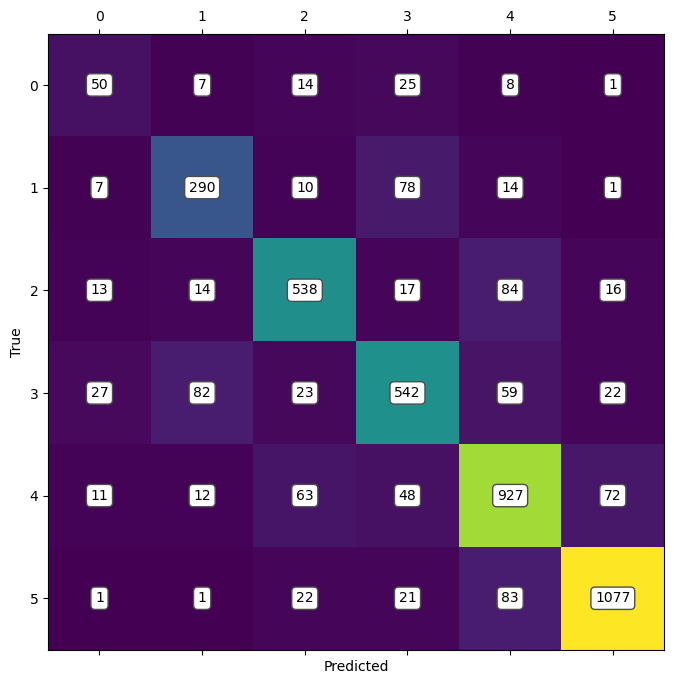

In [35]:
# printing classification report
print("Classification report:")
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))

# plotting confusion matrix
plot_confusion_matrix(  y_true=y_test,
                        y_pred=y_pred,
                        labels=list(set(CLASSES)),
                        color_map="viridis",
                        print_colorbar=False,
                        print_numbers=True,
                        print_boxes=True)